In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d

from tqdm import tqdm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, RFF, continuous_diff
from train import train_siren

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [4]:
# Load Data
path_to_csv0 = Path("../../data/clippeddata/clippedMarco0.txt")
path_to_csv1 = Path("../../data/clippeddata/clippedMarco1.txt")

data_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,:3]
data_t0 = np.concatenate([data_t0, np.zeros((data_t0.shape[0],1))], axis=-1)

col_names = ["x","y","z","t"]

In [5]:
data = data_t0

do_preprocessing = False
if do_preprocessing:
    pts = data[:,:3]
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)

    o3d.visualization.draw_geometries([pcd])
    ## prune points with horizontal norms
    radius =  3. # metres
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
    dist, az, el = [1000, 0, 80]
    campera_loc_car = np.array([
        dist*np.cos(np.deg2rad(el))*np.cos(np.deg2rad(az)),
        dist*np.cos(np.deg2rad(el))*np.sin(np.deg2rad(az)),
        dist*np.sin(np.deg2rad(el))
    ])
    pcd.orient_normals_towards_camera_location(
        camera_location=campera_loc_car)
    o3d.visualization.draw_geometries([pcd], point_show_normal=True)


    normals = np.asarray(pcd.normals)
    hpnorm = np.array([0,0,1])

    angles = np.arccos(np.abs(normals @ hpnorm) / (
        np.linalg.norm(normals, axis=1) * np.linalg.norm(hpnorm) ))

    plt.hist(np.rad2deg(angles), bins=90)
    plt.show()

    print(np.rad2deg(angles))
    ind = np.where(np.abs(np.rad2deg(angles)) > 70)[0]
    print(ind.shape)

    pcd = pcd.select_by_index(ind, invert=True)
    o3d.visualization.draw_geometries([pcd], point_show_normal=True)

    ## prune isolated points
    radius = 1 # meter
    nb_points = 1
    cl, ind = pcd.remove_radius_outlier(nb_points=nb_points, radius=radius)
    pcd = pcd.select_by_index(ind)
    # outlier_cloud = downpcd.select_by_index(ind, invert=True)
    o3d.visualization.draw_geometries([pcd], point_show_normal=True)

    data_t0_post = np.array(pcd.points)
    data_t0_post = np.concatenate([data_t0_post, np.zeros((data_t0_post.shape[0],1))], axis=-1)
    data_t0 = data_t0_post

In [6]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        coords = torch.Tensor(self.data[:,[0,1,3]]).to(device)
        target = torch.Tensor(self.data[:,2][:,None]).to(device)
        
        # target normalization between [-1,1] for SIREN
        self.target_mean = torch.mean(target, dim=0, keepdim=True)
        target = target - self.target_mean
        self.target_range = 1.1 * torch.max(torch.abs(target))
        self.target = target / self.target_range

        # coordinate normalization between [-1,1] for SIREN
        coords_n = coords - torch.mean(coords, dim=0, keepdim=True)
        coords_n = coords_n / (1.1 * torch.max(torch.abs(coords_n), dim=0, keepdim=True)[0])
        coords[:,:2] = coords_n[:,:2]
        self.coords = coords
        
        for d in range(2):
            assert torch.max(self.coords[:,d]) <  1
            assert torch.min(self.coords[:,d]) > -1
            assert torch.any(self.coords[:,d] <= 0)
        
        print('Coords')
        print(torch.min(self.coords, dim=0)[0])
        print(torch.mean(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])

        print('Targets')
        print(torch.min(self.target, dim=0)[0])
        print(torch.mean(self.target, dim=0)[0])
        print(torch.max(self.target, dim=0)[0])
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dset_t0 = MarcoDataset(data_t0, col_names, device)

dset_train = dset_t0
n_obs = len(dset_train)
print(n_obs)

n_val  = int((20 / 100) * n_obs)
n_train = n_obs - n_val

dset_train, dset_val = torch.utils.data.random_split(dset_train, [n_train, n_val])

n_points = 512
xy_cont = np.stack(np.meshgrid(
    np.linspace(-1, 1, n_points),
    np.linspace(-1, 1, n_points),
    np.array([0.]),
    indexing='ij'
), axis=-1)
xy_cont = torch.from_numpy(xy_cont).float().to(device)
xy_cont = xy_cont.view(-1,3)

cuda
Coords
tensor([-0.9091, -0.9091,  0.0000], device='cuda:0')
tensor(-1.0381e-08, device='cuda:0')
tensor([0.8144, 0.9070, 0.0000], device='cuda:0')
Targets
tensor([-0.8172], device='cuda:0')
tensor(3.0970e-07, device='cuda:0')
tensor([0.9091], device='cuda:0')
24253


In [57]:
params = {'batch_size': 512,
 'feature_space': 30,
 'feature_time': 20,
 'hidden_dim': 256,
 'hidden_num': 3,
 'learning_rate': 1e-5}
epochs = 1000


class INCANT(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden_num, hidden_dim, feature_scales):
        super(INCANT, self).__init__()
        self.model = SIREN(in_dim, out_dim, hidden_num, hidden_dim, feature_scales)
        # self.model = RFF(in_dim, out_dim, hidden_num, hidden_dim, 'relu', feature_dim=1024, feature_scale=feature_scales[0] )

    # extend SIREN forward
    def forward(self, xin):
        return torch.tanh(self.model(xin))

model = INCANT(
    in_dim = 3,
    out_dim = 1,
    hidden_num = params['hidden_num'],
    hidden_dim = params['hidden_dim'],
    feature_scales = [params['feature_space'], params['feature_space'], params['feature_time']]
)
epochs = 100

best_model, results_dict = train_siren(
        model, dset_train, dset_val, device, epochs, loss_name='MSE',
        batch_size=params['batch_size'], learning_rate=params['learning_rate'],
        val_interval=10, trial=None, xy_cont=xy_cont, lam_tv = 0.1, clip_grad=False)


1e-05 512 MSE


Train Epoch [12/100] Loss: 0.30465, Metric: 0.25438:  13%|█▎        | 13/100 [00:09<01:01,  1.42it/s]

Early stopping
Best model from epoch 8


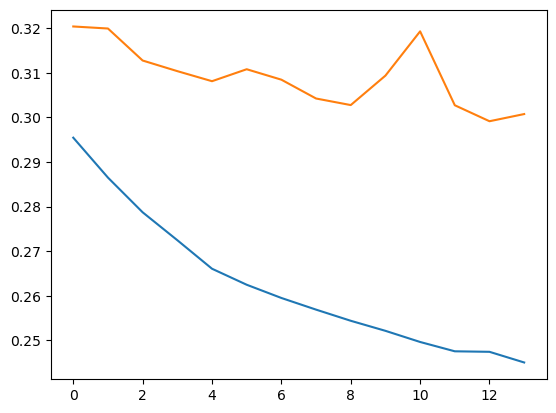

In [58]:
plt.plot(results_dict['loss_train'], label='train')
plt.plot(results_dict['loss_val'], label='val')
plt.show()

In [61]:
coord_test, reference = dset_val[:]
print(coord_test)
print(coord_test.dtype)
estimaded = best_model(coord_test)

estimaded = (estimaded * dset_t0.target_range) + dset_t0.target_mean
reference = (reference * dset_t0.target_range) + dset_t0.target_mean

error = torch.abs(estimaded - reference)
mae = torch.mean(error)
std = torch.std(error)
mse = torch.mean(error**2)
smse = torch.sqrt(mse)
print(f'MAE: {mae.item():0.4f} MSE: {mse.item():0.4f} STD: {std.item():0.4f} sMSE: {smse.item():0.4f}')

tensor([[ 0.5920,  0.0797,  0.0000],
        [-0.2308,  0.2815,  0.0000],
        [ 0.4178,  0.2411,  0.0000],
        ...,
        [-0.5236, -0.4046,  0.0000],
        [ 0.7106, -0.3037,  0.0000],
        [-0.5866, -0.1019,  0.0000]], device='cuda:0')
torch.float32
MAE: 7.6018 MSE: 64.3207 STD: 2.5564 sMSE: 8.0200


tensor([[-0.1122, -0.8486,  0.0000],
        [-0.6756,  0.7859,  0.0000],
        [-0.1307,  0.8666,  0.0000],
        ...,
        [-0.2086,  0.8263,  0.0000],
        [ 0.7181, -0.5055,  0.0000],
        [ 0.3919, -0.8284,  0.0000]], device='cuda:0')
torch.float32


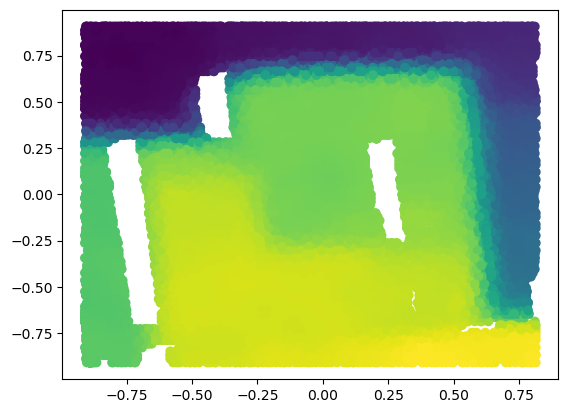

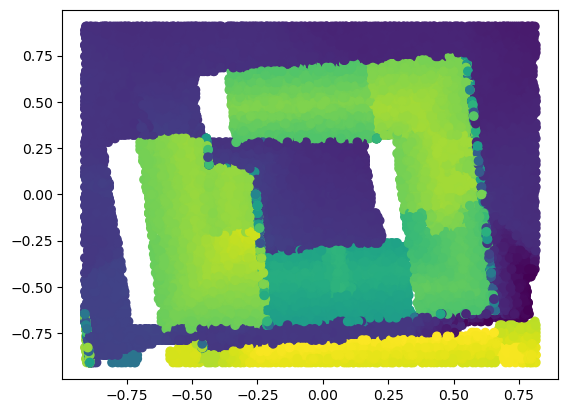

MAE: 7.6201 MSE: 64.8215 STD: 2.5993 sMSE: 8.0512


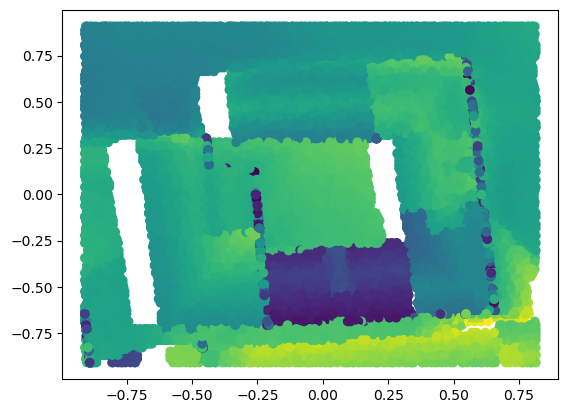

In [62]:
coord_test, reference = dset_train[:]
print(coord_test)
print(coord_test.dtype)
best_model.eval()
estimaded = best_model(coord_test)

plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
            coord_test[:,1].detach().cpu().numpy(), 
            c=estimaded.detach().cpu().numpy())
plt.show()

plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
            coord_test[:,1].detach().cpu().numpy(), 
            c=reference.detach().cpu().numpy())
plt.show()

estimaded = (estimaded * dset_t0.target_range) + dset_t0.target_mean
reference = (reference * dset_t0.target_range) + dset_t0.target_mean

error = torch.abs(estimaded - reference)
mae = torch.mean(error)
std = torch.std(error)
mse = torch.mean(error**2)
smse = torch.sqrt(mse)
print(f'MAE: {mae.item():0.4f} MSE: {mse.item():0.4f} STD: {std.item():0.4f} sMSE: {smse.item():0.4f}')

plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
            coord_test[:,1].detach().cpu().numpy(), 
            c=error.detach().cpu().numpy())
plt.show()


In [63]:
n_points = 512
xy_cont = np.stack(np.meshgrid(
    np.linspace(-0.9, 0.9, n_points),
    np.linspace(-0.9, 0.9, n_points),
    np.array([0.]),
    indexing='ij'
), axis=-1).reshape(-1,3)

xy_cont = torch.from_numpy(xy_cont).float().to(device)

best_model.eval()
estimaded = best_model(xy_cont)
estimaded = estimaded.reshape(n_points, n_points)

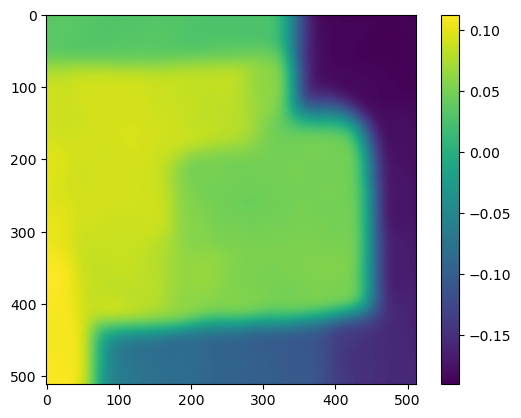

In [64]:
plt.imshow(estimaded.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [30]:
print(xy_cont.shape)
print(estimaded.shape)

pts = torch.concat([xy_cont[:,:2], estimaded.view(-1,1)], dim=-1).view(-1,3).detach().cpu().numpy()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

o3d.visualization.draw_geometries([pcd])

torch.Size([262144, 3])
torch.Size([512, 512])


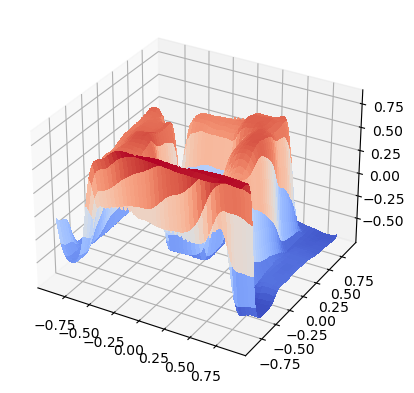

In [50]:
# Plot the surface.
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = pts[:,0].reshape(512,512)
y = pts[:,1].reshape(512,512)
z = pts[:,2].reshape(512,512)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)